<a href="https://colab.research.google.com/github/iscel15/Data-Science-Projects/blob/main/An%C3%A1lisis_de_un_Cubo_Espectrosc%C3%B3pico_Estimaci%C3%B3n_de_Ruido%2C_M%C3%A1scara_de_Se%C3%B1al_y_Mapas_de_Momentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install spectral-cube dask numpy matplotlib astropy
%pip install --pre -U astroquery

In [ ]:
# ============================================
# Paso 1: Lectura del cubo espectroscópico
# ============================================

import numpy as np
from astropy.utils.data import download_file
from spectral_cube import SpectralCube

# Ruta local del archivo FITS (previamente cargado en Colab)
file_path = '/content/source05_HI.fits'

# Lectura del cubo utilizando SpectralCube
cube = SpectralCube.read(file_path)

# Visualización básica: dimensiones espaciales/espectrales y unidades
cube


VaryingResolutionSpectralCube with shape=(93, 400, 400) and unit=Jy / beam:
 n_x:    400  type_x: RA---SIN  unit_x: deg    range:    86.043649 deg:   87.298078 deg
 n_y:    400  type_y: DEC--SIN  unit_y: deg    range:    26.817581 deg:   27.925932 deg
 n_s:     93  type_s: VOPT      unit_s: m / s  range:   500998.957 m / s: 1331793.681 m / s

In [ ]:
# ============================================
# Paso 2: Header, v_opt central y conversión a v_radio
# ============================================

from astropy.io import fits
import astropy.units as u

# --- 2.1 Header FITS: nombre del objeto y metadatos relevantes ---
hdr = fits.getheader(file_path)

obj_name   = hdr.get('OBJECT', 'DESCONOCIDO')
rest_freq  = hdr.get('RESTFRQ', hdr.get('RESTFREQ', None))  # Hz, si existe
spec_unit  = hdr.get('CUNIT3', 'NA')                        # unidad eje espectral
spec_type  = hdr.get('CTYPE3', 'NA')                        # tipo eje (VOPT, VRAD, FREQ, etc.)
crval3     = hdr.get('CRVAL3', None)                        # valor de referencia eje 3
crpix3     = hdr.get('CRPIX3', None)                        # píxel de referencia
cdelt3     = hdr.get('CDELT3', None)                        # incremento por canal

print(f"Objeto (OBJECT): {obj_name}")
print(f"RESTFRQ/RESTFREQ: {rest_freq} Hz" if rest_freq is not None else "RESTFRQ/RESTFREQ: no especificado")
print(f"Eje espectral: CTYPE3={spec_type}, CUNIT3={spec_unit}")
print(f"CRVAL3={crval3}, CRPIX3={crpix3}, CDELT3={cdelt3}")

# Si el header no define la frecuencia de reposo, utilizar HI 1420.40575177 MHz
if rest_freq is None:
    rest_freq = (1.42040575177 * u.GHz).to_value(u.Hz)

# --- 2.2 Velocidad óptica central del cubo ---
# Definición operativa: valor de la velocidad en el canal central.
spec_axis_opt = cube.spectral_axis.to(u.m/u.s)  # debería venir en VOPT (m/s)
i_c = spec_axis_opt.size // 2
vopt_central = spec_axis_opt[i_c].to(u.km/u.s)

print(f"\nVelocidad óptica central (canal medio): {vopt_central:.3f}")

# --- 2.3 Conversión del eje espectral a velocidad de radio (km/s) ---
# Usamos la misma frecuencia de reposo para garantizar consistencia.
cube_radio = cube.with_spectral_unit(u.km/u.s,
                                     velocity_convention='radio',
                                     rest_value=rest_freq * u.Hz)

# --- 2.4 Velocidad central en convención de radio ---
spec_axis_radio = cube_radio.spectral_axis.to(u.km/u.s)
vrad_central = spec_axis_radio[i_c]

print(f"Velocidad central en convención RADIO (canal medio): {vrad_central:.3f}")

# (Opcional) Guardar referencia al cubo en unidades de trabajo para el resto de la tarea
cube_work = cube_radio  # trabajaremos en km/s, convención radio, como pide el enunciado


Objeto (OBJECT): J0546+2722
RESTFRQ/RESTFREQ: 1420400000.0 Hz
Eje espectral: CTYPE3=VOPT, CUNIT3=m/s
CRVAL3=500998.9567946, CRPIX3=1.0, CDELT3=9030.377434188

Velocidad óptica central (canal medio): 916.396 km / s
Velocidad central en convención RADIO (canal medio): 913.604 km / s


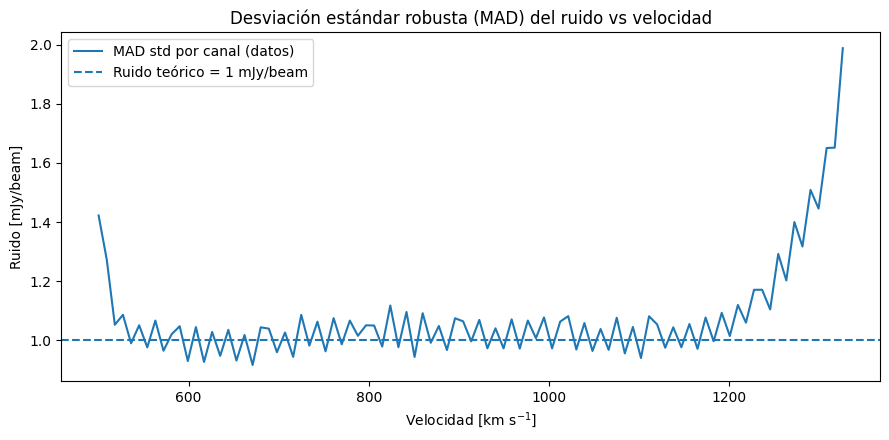

In [ ]:
# ============================================
# 3.1 Ruido por canal (MAD std) y comparación con 1 mJy/beam
# ============================================

import matplotlib.pyplot as plt

# Trabajamos con el cubo ya convertido a km/s en convención RADIO:
# cube_work = cube_radio  (definido en el paso 2)

# Ruido robusto por canal (colapsando las dimensiones espaciales)
mad_std_per_chan = cube_work.mad_std(axis=(1, 2))  # -> Quantity con unidad del cubo (p.ej., Jy/beam)

# Convertir a mJy/beam para comparar con el valor teórico
mad_std_mJy = mad_std_per_chan.to(u.mJy / u.beam)

vel_kms = cube_work.spectral_axis.to(u.km/u.s).value  # eje de velocidades para graficar
theory_noise = 1.0  # mJy/beam

plt.figure(figsize=(9,4.5))
plt.plot(vel_kms, mad_std_mJy.value, lw=1.5, label='MAD std por canal (datos)')
plt.axhline(theory_noise, ls='--', label='Ruido teórico = 1 mJy/beam')
plt.xlabel('Velocidad [km s$^{-1}$]')
plt.ylabel('Ruido [mJy/beam]')
plt.title('Desviación estándar robusta (MAD) del ruido vs velocidad')
plt.legend()
plt.tight_layout()
plt.show()


Mediana MAD  [antes]:   1.045 mJy/beam
Mediana MAD  [después]: 1.045 mJy/beam
P95 MAD      [antes]:   1.431 mJy/beam
P95 MAD      [después]: 1.431 mJy/beam


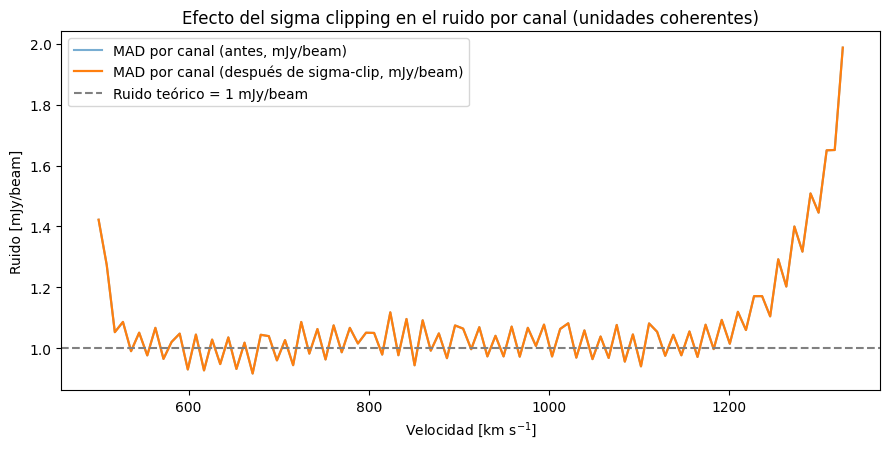

<Figure size 640x480 with 0 Axes>

In [ ]:
# ========= Arreglo de unidades y comparación =========

try:
    cube_sclip  # referencia
except NameError:
    cube_sclip = cube_work.sigma_clip_spectrally(threshold=3)

# Recalcular desde el cubo para evitar residuos de variables previas
mad_before_q = cube_work.mad_std(axis=(1, 2))                    # Quantity (ej. Jy/beam)
mad_after_q  = cube_sclip.mad_std(axis=(1, 2))                   # Quantity

# Convertir AMBAS a mJy/beam y a ndarray puro
mad0_arr = mad_before_q.to_value(u.mJy/u.beam).astype(float)
mad1_arr = mad_after_q.to_value(u.mJy/u.beam).astype(float)

# Métricas
median_before = np.nanmedian(mad0_arr)
median_after  = np.nanmedian(mad1_arr)
p95_before    = np.nanpercentile(mad0_arr, 95)
p95_after     = np.nanpercentile(mad1_arr, 95)

print(f"Mediana MAD  [antes]:   {median_before:.3f} mJy/beam")
print(f"Mediana MAD  [después]: {median_after:.3f} mJy/beam")
print(f"P95 MAD      [antes]:   {p95_before:.3f} mJy/beam")
print(f"P95 MAD      [después]: {p95_after:.3f} mJy/beam")

# Eje de velocidades (km/s)
vel_kms = cube_work.spectral_axis.to(u.km/u.s).value

# Gráfico coherente (mismas unidades)
plt.figure(figsize=(9,4.6))
plt.plot(vel_kms, mad0_arr, alpha=0.6, label='MAD por canal (antes, mJy/beam)')
plt.plot(vel_kms, mad1_arr, lw=1.6, label='MAD por canal (después de sigma-clip, mJy/beam)')
plt.axhline(1.0, ls='--', color='gray', label='Ruido teórico = 1 mJy/beam')
plt.xlabel('Velocidad [km s$^{-1}$]')
plt.ylabel('Ruido [mJy/beam]')
plt.title('Efecto del sigma clipping en el ruido por canal (unidades coherentes)')
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig('/content/fig_03_ruido_vs_vel.png', dpi=300, bbox_inches='tight')


/usr/local/lib/python3.12/dist-packages/radio_beam/multiple_beams.py:278: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/usr/local/lib/python3.12/dist-packages/radio_beam/multiple_beams.py:278: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/usr/local/lib/python3.12/dist-packages/radio_beam/multiple_beams.py:278: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


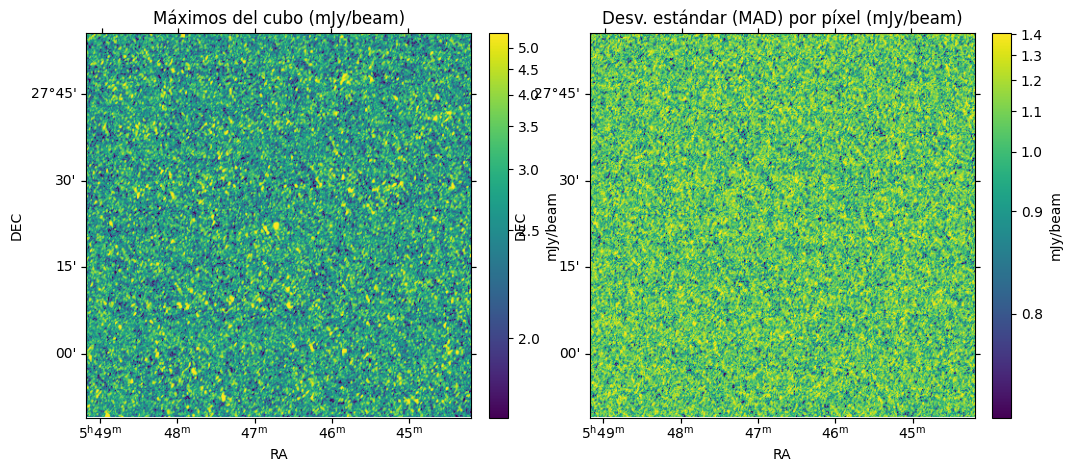

In [ ]:
# ============================================
# 4.1 Mapas: máximos del cubo y ruido por píxel
# ============================================
from astropy.visualization import simple_norm
from astropy.wcs import WCS

# --- 4.1.1 Mapa de máximos (sobre el eje espectral) ---
# Resultado: imagen 2D (RA, DEC) con el valor máximo por canal en cada píxel
max_map = cube_work.max(axis=0).to(u.mJy/u.beam)  # a mJy/beam para lectura directa

# --- 4.1.2 Mapa de ruido por píxel (MAD a lo largo del eje espectral) ---
# Sigma-clip espectral suave para evitar que la señal fuerte sesgue el MAD
cube_sclip = cube_work.sigma_clip_spectrally(threshold=3)
noise_map = cube_sclip.mad_std(axis=0).to(u.mJy/u.beam)  # MAD en cada píxel (mJy/beam)

# --- 4.1.3 Visualización lado a lado con WCS ---
wcs2d = WCS(cube_work.wcs.celestial.to_header())

fig, axs = plt.subplots(1, 2, figsize=(12,5), subplot_kw={'projection': wcs2d})
plt.subplots_adjust(wspace=0.18)

# Estirado robusto (percentiles) para que se aprecien detalles
norm_max   = simple_norm(max_map.value,   'asinh', percent=99.0)
norm_noise = simple_norm(noise_map.value, 'asinh', percent=99.0)

im0 = axs[0].imshow(max_map.value, origin='lower', norm=norm_max)
axs[0].set_title('Máximos del cubo (mJy/beam)')
axs[0].set_xlabel('RA')
axs[0].set_ylabel('DEC')
cbar0 = plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
cbar0.set_label('mJy/beam')

im1 = axs[1].imshow(noise_map.value, origin='lower', norm=norm_noise)
axs[1].set_title('Desv. estándar (MAD) por píxel (mJy/beam)')
axs[1].set_xlabel('RA')
axs[1].set_ylabel('DEC')
cbar1 = plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
cbar1.set_label('mJy/beam')

plt.show()


In [ ]:
# ============================================
# 4.2 Chequeo cuantitativo de co-localización
# ============================================

max_arr   = max_map.value.astype(float)
noise_arr = noise_map.value.astype(float)

# Correlación lineal global (pixel a pixel)
corr = np.corrcoef(max_arr.ravel(), noise_arr.ravel())[0,1]
print(f"Correlación píxel a píxel (máximo vs ruido): r = {corr:.3f}")

# Máscara de fuentes brillantes: percentil alto del mapa de máximos
pct = 98.0  # ajustable: 95–99 según cuán selectivo se quiera ser
th_bright = np.nanpercentile(max_arr, pct)
src_mask = max_arr >= th_bright

noise_in  = noise_arr[src_mask]
noise_out = noise_arr[~src_mask]

print(f"Ruido MAD (mJy/beam) en regiones brillantes (>{pct:.0f}º pct): "
      f"mediana={np.nanmedian(noise_in):.3f}, p95={np.nanpercentile(noise_in,95):.3f}")
print(f"Ruido MAD (mJy/beam) fuera de esas regiones: "
      f"mediana={np.nanmedian(noise_out):.3f}, p95={np.nanpercentile(noise_out,95):.3f}")


Correlación píxel a píxel (máximo vs ruido): r = 0.073
Ruido MAD (mJy/beam) en regiones brillantes (>98º pct): mediana=1.054, p95=1.287
Ruido MAD (mJy/beam) fuera de esas regiones: mediana=1.048, p95=1.270


/usr/local/lib/python3.12/dist-packages/radio_beam/multiple_beams.py:278: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/usr/local/lib/python3.12/dist-packages/radio_beam/multiple_beams.py:278: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


[5] Regiones conectadas encontradas: 20290
[5] Regiones aceptadas (low≥48, high≥15): 1
[5] Regiones finales tras crecimiento: 1


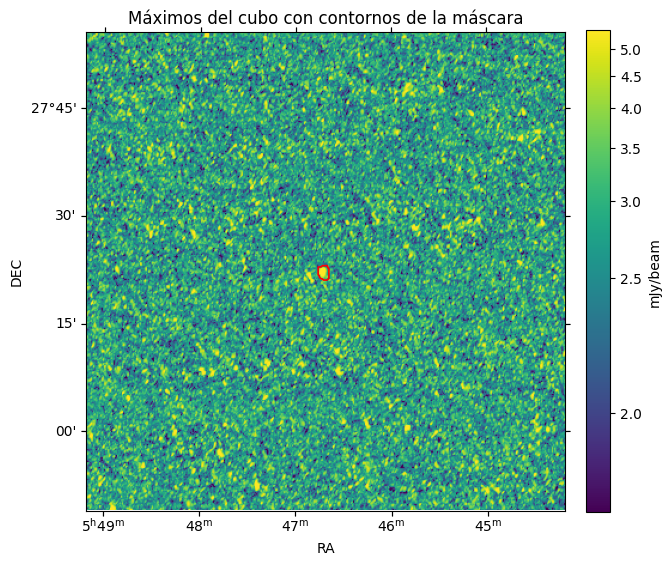

In [ ]:
# ============================================
# Paso 5: Máscara de señal (SNR + conectividad + morfología)
# ============================================
import matplotlib.pyplot as plt
from scipy.ndimage import label, binary_dilation
from astropy.visualization import simple_norm

# ---------- 5.0 Parámetros (ajustables según el dataset) ----------
low_sigma     = 3.0     # umbral SNR bajo (detección candidata)
high_sigma    = 6.0     # umbral SNR alto (núcleo robusto)
min_low_vox   = 48      # mínimo de vóxeles con SNR>=low por región
min_high_vox  = 15      # mínimo de vóxeles con SNR>=high por región
grow_xy_iters = 1       # crecimiento morfológico en RA/DEC
grow_v_iters  = 1       # crecimiento morfológico en eje espectral

# ---------- 5.1 Mapa de ruido por píxel (MAD a lo largo del eje espectral) ----------
# Sigma-clip suave para evitar que la señal sesgue el MAD por píxel
cube_sclip_px = cube_work.sigma_clip_spectrally(threshold=3)

# MAD por píxel (resultado es Quantity con unidad del cubo)
noise_map = cube_sclip_px.mad_std(axis=0).to(u.mJy/u.beam)   # (ny, nx) en mJy/beam

# ---------- 5.2 Máscaras SNR voxel-a-voxel ----------
# Elevar noise_map a 3D para comparar con el cubo; trabajar con valores (sin unidades) para máscaras
noise_3d = noise_map.value[None, :, :]                       # (1, ny, nx) -> broadcast a (ns, ny, nx)

# EXTRAER datos del cubo como Quantity y convertir a mJy/beam
# filled_data()[:] -> devuelve Quantity con la unidad del cubo
cube_q = cube_work.filled_data[:]

cube_val = cube_q.to_value(u.mJy/u.beam)                     # (ns, ny, nx) en mJy/beam (float)

low_snr_mask  = (cube_val > low_sigma  * noise_3d)
high_snr_mask = (cube_val > high_sigma * noise_3d)

# ---------- 5.3 Conectividad 3D y filtros por tamaño/robustez ----------
# Estructura 6-vecinos (caras compartidas) para etiquetado 3D
structure = np.zeros((3,3,3), dtype=bool)
structure[1,:,1] = True  # Y
structure[:,1,1] = True  # Z (espectral)
structure[1,1,:] = True  # X

labels, n_regions = label(low_snr_mask, structure=structure)

# Conteo de voxeles low/high por región
low_counts  = np.bincount(labels.ravel(), minlength=n_regions+1)[1:]  # excluye fondo (0)
high_counts = np.zeros(n_regions, dtype=int)
for rid in range(1, n_regions+1):
    high_counts[rid-1] = np.count_nonzero(high_snr_mask & (labels == rid))

# Criterios de aceptación (tamaño low + presencia de núcleo high)
keep = (low_counts >= min_low_vox) & (high_counts >= min_high_vox)
accepted_labels = (np.nonzero(keep)[0] + 1)  # labels válidas (sin el 0)

accepted_mask = np.isin(labels, accepted_labels)
print(f"[5] Regiones conectadas encontradas: {n_regions}")
print(f"[5] Regiones aceptadas (low≥{min_low_vox}, high≥{min_high_vox}): {keep.sum()}")

# ---------- 5.4 Crecimiento morfológico (espacial y espectral) ----------
mask = accepted_mask.copy()

# Crecimiento espacial (3x3 en RA/DEC, sin expandir en espectral)
if grow_xy_iters > 0:
    struct_xy = np.zeros((1,3,3), dtype=bool)
    struct_xy[0,:,:] = True
    mask = binary_dilation(mask, structure=struct_xy, iterations=grow_xy_iters)

# Crecimiento espectral (3 en eje de canales, sin expandir en RA/DEC)
if grow_v_iters > 0:
    struct_v = np.zeros((3,1,1), dtype=bool)
    struct_v[:,0,0] = True
    mask = binary_dilation(mask, structure=struct_v, iterations=grow_v_iters)

# Re-etiquetar tras el crecimiento para saber el número final de regiones
labels_final, n_regions_final = label(mask, structure=structure)
print(f"[5] Regiones finales tras crecimiento: {n_regions_final}")

# ---------- 5.5 Cubo enmascarado para pasos siguientes ----------
masked_cube = cube_work.with_mask(mask)

# ---------- 5.6 Visualización: contornos de la máscara sobre el mapa de máximos ----------
# Proyección 2D de la máscara: cualquier canal verdadero
mask_2d = mask.max(axis=0)

# Mapa de máximos (si no existe) en mJy/beam
try:
    max_map
except NameError:
    max_map = cube_work.max(axis=0).to(u.mJy/u.beam)

wcs2d   = WCS(cube_work.wcs.celestial.to_header())
normmax = simple_norm(max_map.value, 'asinh', percent=99.0)

fig = plt.figure(figsize=(6.8,5.9))
ax  = plt.subplot(1,1,1, projection=wcs2d)
im  = ax.imshow(max_map.value, origin='lower', norm=normmax)
ax.contour(mask_2d.astype(float), levels=[0.5], colors='red', linewidths=1.2, origin='lower')
ax.set_title('Máximos del cubo con contornos de la máscara')
ax.set_xlabel('RA'); ax.set_ylabel('DEC')
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('mJy/beam')
plt.tight_layout(); plt.show()


/usr/local/lib/python3.12/dist-packages/radio_beam/multiple_beams.py:278: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/usr/local/lib/python3.12/dist-packages/radio_beam/multiple_beams.py:278: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/usr/local/lib/python3.12/dist-packages/spectral_cube/_moments.py:182: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /


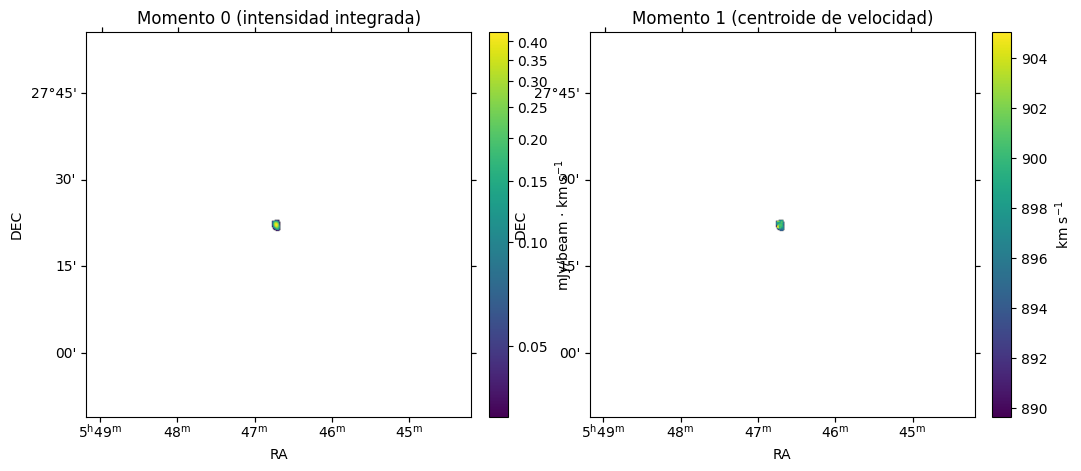

In [ ]:
# ============================================
# 6.1 Momentos 0 y 1 del cubo enmascarado
# ============================================

# --- Cubo a usar para los momentos (enmascarado por señal)
cube_to_use = masked_cube  # si se quiere comparar, usar también cube_work

# --- Momento 0: intensidad integrada ---
# Unidades: (mJy/beam) * (km/s)  ->  mJy/beam km/s
m0 = cube_to_use.moment0()  # integra a lo largo del eje espectral

# --- Momento 1: centroide de velocidad ---
# Unidades: km/s
# Se calcula como (∑ v I) / (∑ I); requiere que m0 > 0 (la máscara ayuda a evitar negativos)
m1 = cube_to_use.moment1()

# --- Visualización con WCS ---
wcs2d = WCS(cube_to_use.wcs.celestial.to_header())

fig, axs = plt.subplots(1, 2, figsize=(12,5), subplot_kw={'projection': wcs2d})
plt.subplots_adjust(wspace=0.18)

# Escalados robustos
norm_m0 = simple_norm(m0.value, 'asinh', percent=99.0)
norm_m1 = simple_norm(m1.value, 'linear', percent=99.0)

im0 = axs[0].imshow(m0.value, origin='lower', norm=norm_m0)
axs[0].set_title('Momento 0 (intensidad integrada)')
axs[0].set_xlabel('RA'); axs[0].set_ylabel('DEC')
c0 = plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
c0.set_label('mJy/beam · km s$^{-1}$')

im1 = axs[1].imshow(m1.value, origin='lower', norm=norm_m1)
axs[1].set_title('Momento 1 (centroide de velocidad)')
axs[1].set_xlabel('RA'); axs[1].set_ylabel('DEC')
c1 = plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
c1.set_label('km s$^{-1}$')

plt.show()


In [ ]:
# ============================================
# 6.2 Métricas descriptivas (útiles para el informe)
# ============================================

# Evitar NaNs en estadísticas
m0_vals = m0.value[np.isfinite(m0.value)]
m1_vals = m1.value[np.isfinite(m1.value)]

def q(a, ps=[5,50,95]):
    return {f"p{p}": float(np.percentile(a, p)) for p in ps}

print("Momento 0 (mJy/beam km/s):")
print("  min/max:", np.min(m0_vals), "/", np.max(m0_vals))
print("  percentiles:", q(m0_vals))

print("\nMomento 1 (km/s):")
print("  min/max:", np.min(m1_vals), "/", np.max(m1_vals))
print("  percentiles:", q(m1_vals))


Momento 0 (mJy/beam km/s):
  min/max: 0.025404977908413978 / 0.4394687856607312
  percentiles: {'p5': 0.03249190840739347, 'p50': 0.12915430221072316, 'p95': 0.38895479599161087}

Momento 1 (km/s):
  min/max: 889.1643598988616 / 905.1105891197506
  percentiles: {'p5': 892.7710342812819, 'p50': 898.7456214363365, 'p95': 903.1800616839869}
